I always enjoy showing people how much easier Numba makes it to speed up their NumPy-based technical codes.   With Numba, you usually can just write the code with loops and then add a decorator to your function and get speed-ups equivalent to having written the code in another compiled language (like C or Fortran).  

Tonight when I saw this question on Stack Exchange: http://scicomp.stackexchange.com/questions/5473/how-to-express-this-complicated-expression-using-numpy-slices it looked like a perfect opportunity to test Numba again.

So, I copied the looped_ver code from Nat Wilson (modified it slightly to make x[0] = 0) and then decorated it to let Numba compile the code.  The result continues to impress me about the code that Mark Florisson, Jon Riehl, and Siu Kwan Lam have put together.  Here is the equation that is being solved:

$$\displaystyle x_i = \sum_{j=0}^{i-1} k_{i-j} a_{i-j} a_{j}$$


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from numba import jit

def looped_ver(k, a):
    x = np.empty_like(a)
    x[0] = 0.0
    for i in range(1, x.size):
        sm = 0.0
        for j in range(0, i):
            sm += k[i-j,j] * a[i-j] * a[j]
        x[i] = sm
    return x

typed_ver = jit('f8[:](f8[:,:],f8[:])')(looped_ver)
auto_ver = jit(looped_ver)

In [3]:
import time
import numpy as np
repeat = 3

def getbest(func, *args):
    import time
    best = 1e12
    for i in range(repeat):
        start = time.time()
        func(*args)
        current = time.time() - start
        if current < best:
            best = current
    return best
    

def timeit(N):
    res = {'looped':[], 'auto':[], 'typed':[]}
    for n in N:
        k = np.random.rand(n,n)
        a = np.random.rand(n)
        for version in ['looped', 'auto', 'typed']:
            func = eval('%s_ver' % version)
            res[version].append(getbest(func, k, a))
    return res

In [4]:
N = [100,200,500,1000,5000]
res = timeit(N)

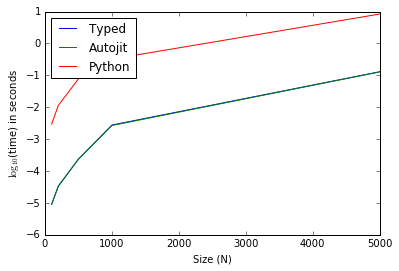

In [5]:
plot(N, log10(res['typed']), N, log10(res['auto']), N, log10(res['looped']))
legend(['Typed', 'Autojit', 'Python'], loc='upper left')
ylabel(r'$\log_{10}$(time) in seconds')
xlabel('Size (N)')

In [6]:
[res['looped'][i]/res['auto'][i] for i in range(len(N))]

[327.2894736842105,
 346.6474820143885,
 327.77878787878785,
 120.89588528678304,
 65.31371303785903]

In [7]:
import numba
print(numba.__version__)

0.29.0.dev+17.g1c27118.dirty


This was run on a Macbook Pro.   Running `sysctl -n machdep.cpu.brand_string` resulted in:

   Intel(R) Core(TM) i7-3720QM CPU @ 2.60GHz